# EDA

Đang tạo biểu đồ so sánh 'Trước' và 'Sau' khi Log Transform...


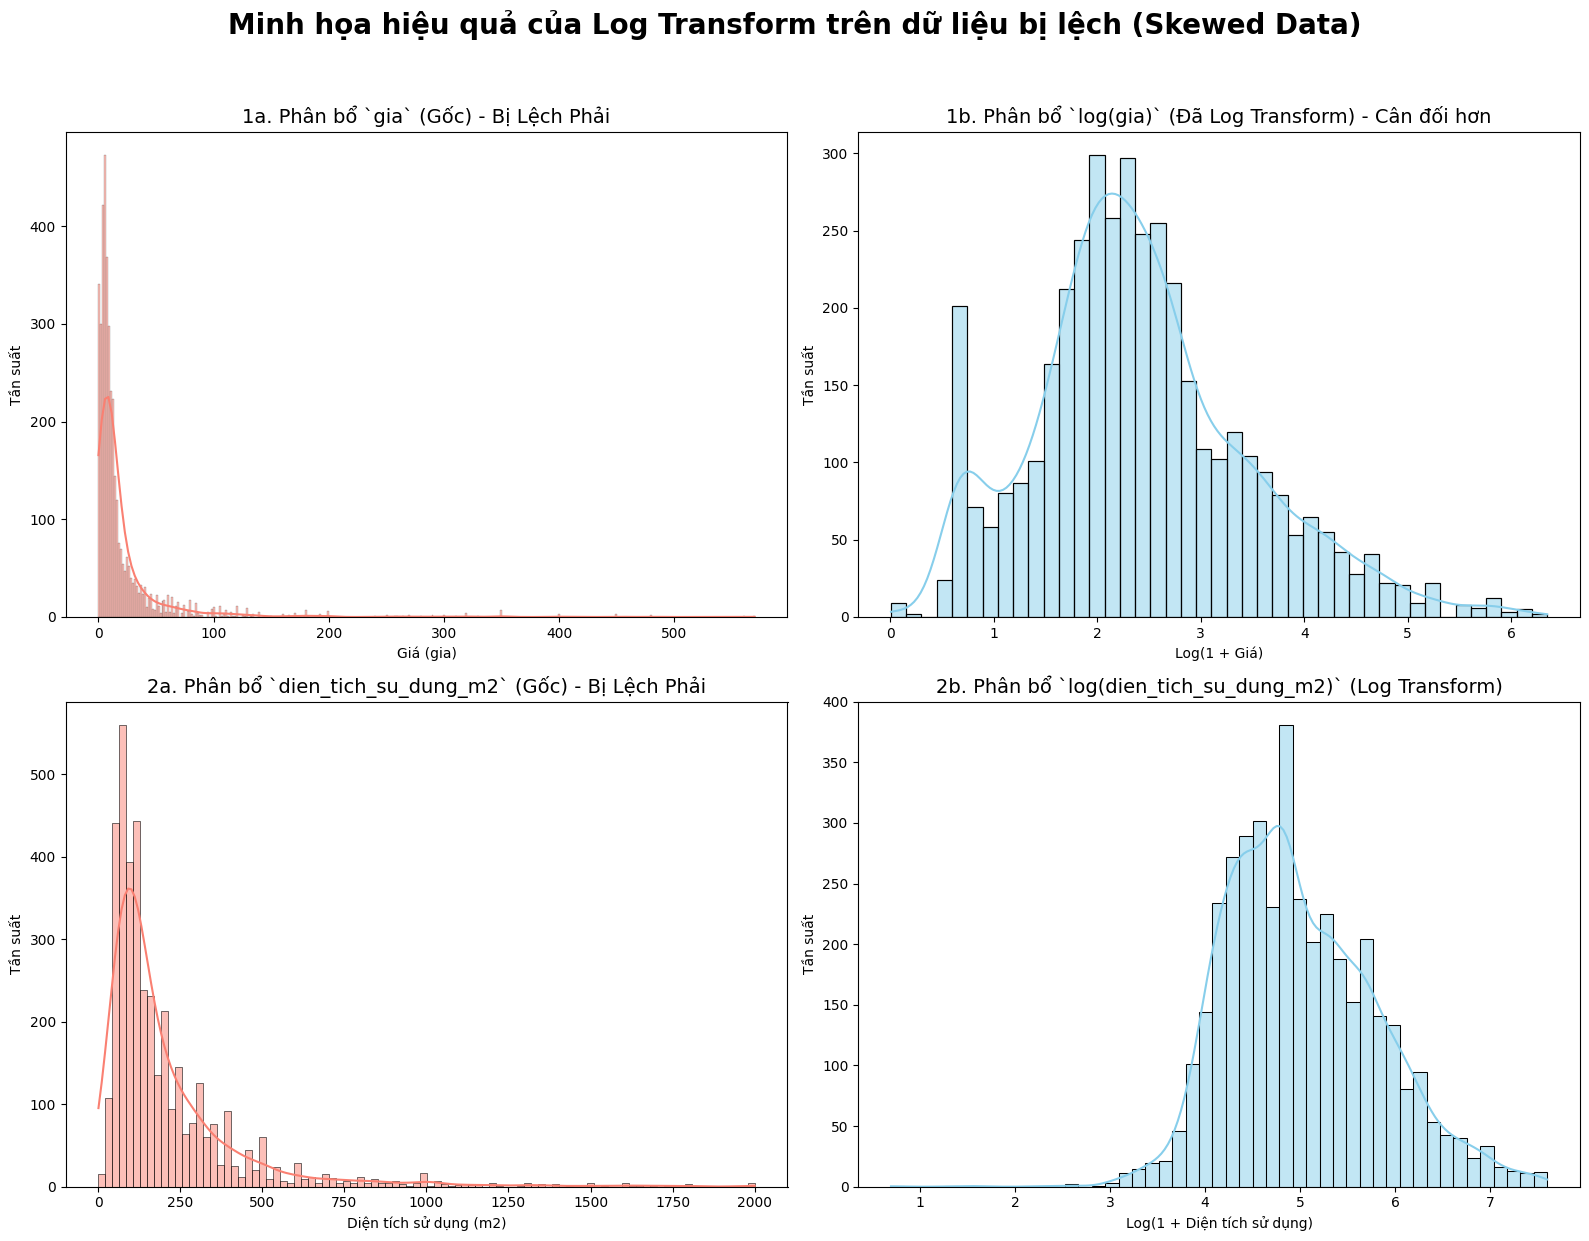

Đã lưu biểu đồ 'log_transform_comparison.png'.


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

try:
    df_data = pd.read_csv("data_predict_price_hourse.csv")
    
    df_clean = df_data[
        (df_data['dien_tich_dat_m2'] <= 1000) &
        (df_data['dien_tich_su_dung_m2'] <= 2000) &
        (df_data['phong_ngu'] <= 10) &
        (df_data['nha_tam'] <= 10)
    ].copy() 

    df_clean['log_gia'] = np.log1p(df_clean['gia'])
    df_clean['log_dien_tich_su_dung_m2'] = np.log1p(df_clean['dien_tich_su_dung_m2'])

    print("Đang tạo biểu đồ so sánh 'Trước' và 'Sau' khi Log Transform...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    sns.histplot(df_clean['gia'], kde=True, ax=axes[0, 0], color='salmon')
    axes[0, 0].set_title('1a. Phân bổ `gia` (Gốc) - Bị Lệch Phải', fontsize=14)
    axes[0, 0].set_xlabel('Giá (gia)')
    axes[0, 0].set_ylabel('Tần suất')

    sns.histplot(df_clean['log_gia'], kde=True, ax=axes[0, 1], color='skyblue')
    axes[0, 1].set_title('1b. Phân bổ `log(gia)` (Đã Log Transform) - Cân đối hơn', fontsize=14)
    axes[0, 1].set_xlabel('Log(1 + Giá)')
    axes[0, 1].set_ylabel('Tần suất')


    sns.histplot(df_clean['dien_tich_su_dung_m2'], kde=True, ax=axes[1, 0], color='salmon')
    axes[1, 0].set_title('2a. Phân bổ `dien_tich_su_dung_m2` (Gốc) - Bị Lệch Phải', fontsize=14)
    axes[1, 0].set_xlabel('Diện tích sử dụng (m2)')
    axes[1, 0].set_ylabel('Tần suất')
    
    sns.histplot(df_clean['log_dien_tich_su_dung_m2'], kde=True, ax=axes[1, 1], color='skyblue')
    axes[1, 1].set_title('2b. Phân bổ `log(dien_tich_su_dung_m2)` (Log Transform)', fontsize=14)
    axes[1, 1].set_xlabel('Log(1 + Diện tích sử dụng)')
    axes[1, 1].set_ylabel('Tần suất')

    plt.suptitle("Minh họa hiệu quả của Log Transform trên dữ liệu bị lệch (Skewed Data)", fontsize=20, fontweight="bold", y=1.03)
    plt.tight_layout()
    plt.savefig("log_transform_comparison.png")
    plt.show()
    
    print("Đã lưu biểu đồ 'log_transform_comparison.png'.")

except FileNotFoundError:
    print("LỖI: Không tìm thấy file 'data_predict_price_hourse.csv'.")
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")

# Model Training

In [19]:
import numpy as np
import pandas as pd
import warnings
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, MinMaxScaler, FunctionTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

try:
    df_data = pd.read_csv("data_predict_price_hourse.csv")
    
    # filter out outliers
    df_clean = df_data[
        (df_data['dien_tich_dat_m2'] <= 1000) &
        (df_data['dien_tich_su_dung_m2'] <= 2000) &
        (df_data['phong_ngu'] <= 10) &
        (df_data['nha_tam'] <= 10)
    ]
    data_model = df_clean.copy()

    #split train, test set
    train_data, test_data = train_test_split(data_model, test_size=0.2, random_state=42)
    
    num_cols = ["dien_tich_dat_m2", "dien_tich_su_dung_m2", "phong_ngu", "nha_tam"]
    cat_cols = ["quan"]

    print("LOG TRANSFROM WITH NUMERICAL FEATURES")
    def train_and_evaluate_pipeline(models, X_train, y_train, X_test, y_test, folder_path_save="Models", names_list=None, preprocess=None):
        model_names = []
        train_rmse_results = []
        test_rmse_results = []
        train_r2_results = []
        test_r2_results = []

        if not os.path.exists(folder_path_save):
            os.makedirs(folder_path_save)

        for name in names_list.keys():
            regression = Pipeline(steps=[
                ("preprocess", preprocess),
                ("regressor", models[names_list[name]])
            ])
            regression = regression.fit(X_train, y_train)
            joblib.dump(regression, f"{folder_path_save}/house_price_{name}_model.joblib")

            y_train_pred = regression.predict(X_train)
            y_test_pred = regression.predict(X_test)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            
            model_names.append(name)
            train_rmse_results.append(train_rmse)
            test_rmse_results.append(test_rmse)
            train_r2_results.append(train_r2)
            test_r2_results.append(test_r2)

        results_df = pd.DataFrame({
            "Model": model_names,
            "Train RMSE": train_rmse_results,
            "Test RMSE": test_rmse_results,
            "Train R2": train_r2_results,
            "Test R2": test_r2_results
        }).sort_values(by="Test R2", ascending=False)
        return results_df
    
    # Pipeline for numerical features with log transform
    numeric_transformer_log = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("log_transformer", FunctionTransformer(np.log1p, validate=False)), 
        ("scaler", MinMaxScaler())
    ])

    # Pipeline for categorical features
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocess_log = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer_log, num_cols),
            ("cat", categorical_transformer, cat_cols),
        ])

    models = {
        "LinearRegression": LinearRegression()
    }
    
    names_list_log = {
        "Linear_log_features": "LinearRegression"
    }

    X_train = train_data.drop(columns=['gia'])
    y_train = train_data['gia']
    X_test = test_data.drop(columns=['gia'])
    y_test = test_data['gia']
    
    result_log_models = train_and_evaluate_pipeline(
        models, 
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        "Models", 
        names_list_log, 
        preprocess_log
    )
    
    print("Results table")
    print(result_log_models)
    
except FileNotFoundError:
    print("'data_predict_price_hourse.csv' not found.")
except Exception as e:
    print(f"Error: {e}")

LOG TRANSFROM WITH NUMERICAL FEATURES
Results table
                 Model  Train RMSE  Test RMSE  Train R2   Test R2
0  Linear_log_features   29.312448  31.955631  0.474701  0.512862


# Model's weight

In [20]:
model_path = "Models/house_price_Linear_log_features_model.joblib"
loaded_model = joblib.load(model_path)

intercept = loaded_model.named_steps['regressor'].intercept_
weights = loaded_model.named_steps['regressor'].coef_

preprocessor = loaded_model.named_steps['preprocess']

cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)

num_features = [f"num__{col}" for col in num_cols]

feature_names = num_features + list(cat_features)

df_weights = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights
})

df_weights['Importance (Abs Weight)'] = np.abs(df_weights['Weight'])
df_weights = df_weights.sort_values(by='Importance (Abs Weight)', ascending=False).drop(columns='Importance (Abs Weight)')

print("\n Coefficient Details")
print(f"Intercept: {intercept:.4f}")
print("Weights of Features:")
print(df_weights.to_string(index=False))

print(f"\ngia = {intercept:.2f} \n")
for i, row in df_weights.head(5).iterrows():
    sign = "+" if row['Weight'] >= 0 else "-"
    # Làm sạch tên đặc trưng
    clean_feature_name = row['Feature'].replace('num__', 'log(1+').replace('cat__', '')
    if 'log' in clean_feature_name:
        clean_feature_name += ')'
    print(f"    {sign} {abs(row['Weight']):.2f} * {clean_feature_name} \n")
print("    + ... (other features)")



 Coefficient Details
Intercept: -103.5056
Weights of Features:
                   Feature     Weight
     num__dien_tich_dat_m2 184.698182
                    quan_3  51.774861
                    quan_1  42.583897
 num__dien_tich_su_dung_m2  26.310092
            num__phong_ngu -16.181542
              num__nha_tam  14.667369
                    quan_9 -14.450039
quan_Thủ Đức (TP. Thủ Đức) -13.731747
                   quan_12 -12.622379
                    quan_7 -12.518409
               quan_Gò Vấp -11.267263
                    quan_8 -10.519756
                    quan_4 -10.516359
                    quan_6  -7.323295
              quan_Tân Phú  -7.222602
                   quan_10   6.940081
             quan_Bình Tân  -6.532182
            quan_Phú Nhuận   5.976489
             quan_Tân Bình  -3.545145
                    quan_5   3.152302
           quan_Bình Thạnh   2.344871
                   quan_11  -1.450304
                    quan_2  -1.073021

gia = -103.51 

    + 1

In [21]:
model = joblib.load("Models/house_price_Linear_log_features_model.joblib")

input_df = pd.DataFrame({
    "quan": ["1"],
    "dien_tich_dat_m2": [40],
    "dien_tich_su_dung_m2": [200],
    "phong_ngu": [10],
    "nha_tam": [11],
})

y_pred = model.predict(input_df)
print(y_pred)

[45.62311766]
